# Multi Agent Collaboration

https://github.com/langchain-ai/langgraph/blob/main/examples/multi_agent/multi-agent-collaboration.ipynb

In [2]:
import boto3

In [3]:
!pip3 install langchain-aws langchain-community langchain --quiet

In [4]:
from botocore.config import Config
from langchain_aws import ChatBedrock
bedrock_region = 'us-east-1'
modelId = "anthropic.claude-3-sonnet-20240229-v1:0"
boto3_bedrock = boto3.client(
    service_name='bedrock-runtime',
    region_name=bedrock_region,
    config=Config(
        retries = {
            'max_attempts': 30
        }            
    )
)

HUMAN_PROMPT = "\n\nHuman:"
AI_PROMPT = "\n\nAssistant:"
maxOutputTokens = 4096
parameters = {
    "max_tokens":maxOutputTokens,     
    "temperature":0.1,
    "top_k":250,
    "top_p":0.9,
    "stop_sequences": [HUMAN_PROMPT]
}    
chat = ChatBedrock(   
    model_id=modelId,
    client=boto3_bedrock, 
    model_kwargs=parameters,
)

In [5]:
from langchain.memory import ConversationBufferWindowMemory
memory_chain = ConversationBufferWindowMemory(memory_key="chat_history", output_key='answer', return_messages=True, k=10)

## Tavily Search

In [6]:
import getpass

api_key = getpass.getpass("Password:")

Password: ········


In [7]:
import os
os.environ["TAVILY_API_KEY"] = api_key

In [8]:
!pip install -U langchain-community tavily-python --quiet

In [9]:
langsmith_api_key = getpass.getpass("Password:")

Password: ········


In [10]:
os.environ["LANGCHAIN_API_KEY"] = langsmith_api_key
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "reflexion agent"

In [11]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages(
    [
        ("system",
            "다음의 Human과 Assistant의 친근한 이전 대화입니다."
            "Assistant은 상황에 맞는 구체적인 세부 정보를 충분히 제공합니다."
            "Assistant의 이름은 서연이고, 모르는 질문을 받으면 솔직히 모른다고 말합니다.",
        ),
        MessagesPlaceholder(variable_name="messages"),
    ]
)
chain = prompt | chat

msg = ""
request = HumanMessage(
    content="2023년 프로야구 우승팀은 누구인가요?"
)

output = chain.stream({"messages": [request]})
for event in output:
    print(event.content, end="")
    msg += event.content
    
msg

안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 포스트시즌 결과에 따라 우승팀이 가려질 테니 조금만 기다려주시면 됩니다. 지금까지의 성적과 전력으로 봤을 때 우승 유력 후보팀들을 알려드릴까요?

'안녕하세요 서연이에요. 2023년 프로야구 시즌이 아직 진행 중이라 우승팀을 정확히 알려드릴 순 없지만, 현재 리그 순위와 각 팀의 전력을 바탕으로 우승 후보팀들을 말씀드릴 수 있어요. 정규시즌 잔여 경기와 포스트시즌 결과에 따라 우승팀이 가려질 테니 조금만 기다려주시면 됩니다. 지금까지의 성적과 전력으로 봤을 때 우승 유력 후보팀들을 알려드릴까요?'

In [12]:
import operator
from typing import Annotated, List, Tuple, TypedDict
from langgraph.graph.message import add_messages
from typing import Annotated, List, Tuple, TypedDict, Literal, Sequence, Union

In [13]:
from langchain_core.pydantic_v1 import BaseModel, Field


In [14]:
selected_chat = 0
LLM_for_chat = [
  {
    "bedrock_region": "us-west-2", # Oregon
    "model_type": "claude3",
    "model_id": "anthropic.claude-3-sonnet-20240229-v1:0"
  }
]

In [ ]:
def get_chat():
    global selected_chat
    
    profile = LLM_for_chat[selected_chat]
    bedrock_region =  profile['bedrock_region']
    modelId = profile['model_id']
    print(f'selected_chat: {selected_chat}, bedrock_region: {bedrock_region}, modelId: {modelId}')
                          
    # bedrock   
    boto3_bedrock = boto3.client(
        service_name='bedrock-runtime',
        region_name=bedrock_region,
        config=Config(
            retries = {
                'max_attempts': 30
            }
        )
    )
    parameters = {
        "max_tokens":maxOutputTokens,     
        "temperature":0.1,
        "top_k":250,
        "top_p":0.9,
        "stop_sequences": [HUMAN_PROMPT]
    }
    # print('parameters: ', parameters)

    chat = ChatBedrock(   # new chat model
        model_id=modelId,
        client=boto3_bedrock, 
        model_kwargs=parameters,
    )    
    
    selected_chat = selected_chat + 1
    if selected_chat == len(LLM_for_chat):
        selected_chat = 0
    
    return chat

In [16]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.utilities.tavily_search import TavilySearchAPIWrapper

search = TavilySearchAPIWrapper()
tavily_tool = TavilySearchResults(api_wrapper=search, max_results=5)

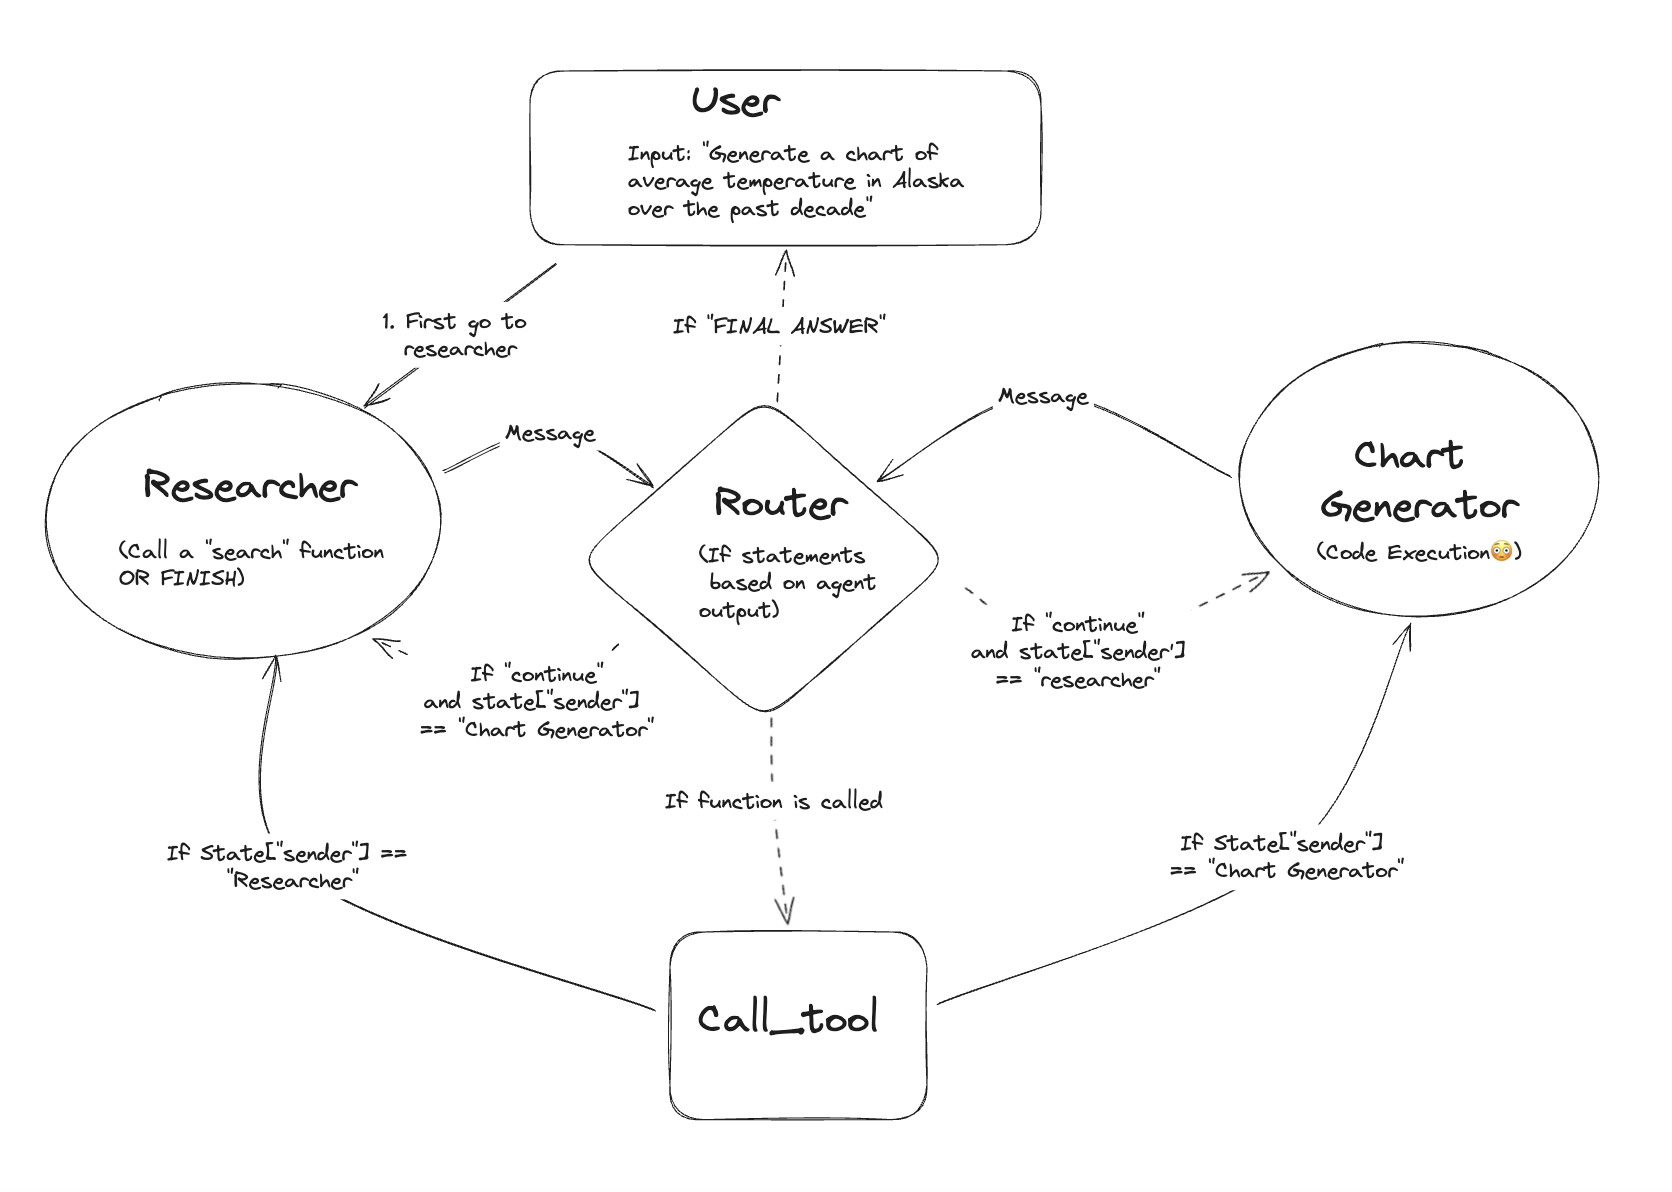

In [17]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

## Define tools

In [21]:
!pip install langchain_experimental --q

In [22]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL

tavily_tool = TavilySearchResults(max_results=5)

# Warning: This executes code locally, which can be unsafe when not sandboxed

repl = PythonREPL()


@tool
def python_repl(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

## Create graph

In [24]:
import operator
from typing import Annotated, Sequence, TypedDict

class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    sender: str

In [25]:
import functools
from langchain_core.messages import AIMessage

# Helper function to create a node for a given agent
def agent_node(state, agent, name):
    result = agent.invoke(state)
    # We convert the agent output into a format that is suitable to append to the global state
    if isinstance(result, ToolMessage):
        pass
    else:
        result = AIMessage(**result.dict(exclude={"type", "name"}), name=name)
    return {
        "messages": [result],
        # Since we have a strict workflow, we can
        # track the sender so we know who to pass to next.
        "sender": name,
    }

In [123]:
def create_agent(llm, tools, system_message: str):
    tool_names = ", ".join([tool.name for tool in tools])
    print("tool_names: ", tool_names)
                           
    system = (
        "You are a helpful AI assistant, collaborating with other assistants."
        "Use the provided tools to progress towards answering the question."
        "If you are unable to fully answer, that's OK, another assistant with different tools "
        "will help where you left off. Execute what you can to make progress."
        "If you or any of the other assistants have the final answer or deliverable,"
        "prefix your response with FINAL ANSWER so the team knows to stop."
        "You have access to the following tools: {tool_names}."
        "{system_message}"
    )
    
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system",system),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
    
    prompt = prompt.partial(system_message=system_message)
    prompt = prompt.partial(tool_names=tool_names)
    
    return prompt | llm.bind_tools(tools)

In [124]:
# Research agent and node
research_agent = create_agent(
    chat,
    [tavily_tool],
    system_message="You should provide accurate data for the chart_generator to use.",
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# chart_generator
chart_agent = create_agent(
    chat,
    [python_repl],
    system_message="Any charts you display will be visible by the user.",
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="chart_generator")

tool_names:  tavily_search_results_json
tool_names:  python_repl


In [37]:
tavily_tool = TavilySearchResults(max_results=5)

In [85]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]
    task: str
    sender: str

In [89]:
def research(state: State):
    tools = [tavily_tool]    
    tool_names = ", ".join([tool.name for tool in tools])
    print("tool_names: ", tool_names)
                           
    system_message="You should provide accurate data for the chart_generator to use."
                           
    system = (
        "You are a helpful AI assistant, collaborating with other assistants."
        "Use the provided tools to progress towards answering the question."
        "If you are unable to fully answer, that's OK, another assistant with different tools "
        "will help where you left off. Execute what you can to make progress."
        "If you or any of the other assistants have the final answer or deliverable,"
        "prefix your response with FINAL ANSWER so the team knows to stop."
        "You have access to the following tools: {tool_names}."
        "{system_message}"
    )
                           
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system",system),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
                               
    chat = get_chat()
    model = chat.bind_tools(tools)
    chain = prompt | model

    result = chain.invoke({
        "tool_names": tool_names,
        "system_message": system_message,
        "messages": state["messages"]
    })
    
    result2 = AIMessage(**result.dict(exclude={"type", "name"}), name="research")
    print('result2: ', result2)

    return {
        "messages": [result]
    }

In [90]:
query = "대한민국의 지난 10년간의 GDP를 찾으세요. 다음에 이 데이터를 가지고 line graph를 그리세요. 준비가 다 되면 마칩니다."

In [91]:
inputs = [HumanMessage(content=query)]
output_research = research({"messages": inputs})

tool_names:  tavily_search_results_json
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0
result2:  content='' additional_kwargs={'usage': {'prompt_tokens': 448, 'completion_tokens': 66, 'total_tokens': 514}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} response_metadata={'usage': {'prompt_tokens': 448, 'completion_tokens': 66, 'total_tokens': 514}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'} name='research' id='run-30260f33-2a1a-4526-be5e-418d7a140237-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'south korea gdp last 10 years'}, 'id': 'toolu_bdrk_01Nso6oVFPYsC9CNDZeNGuck', 'type': 'tool_call'}] usage_metadata={'input_tokens': 448, 'output_tokens': 66, 'total_tokens': 514}


In [94]:
output_research

{'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 448, 'completion_tokens': 66, 'total_tokens': 514}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 448, 'completion_tokens': 66, 'total_tokens': 514}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-30260f33-2a1a-4526-be5e-418d7a140237-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'south korea gdp last 10 years'}, 'id': 'toolu_bdrk_01Nso6oVFPYsC9CNDZeNGuck', 'type': 'tool_call'}], usage_metadata={'input_tokens': 448, 'output_tokens': 66, 'total_tokens': 514})]}

In [95]:
last_message = output_research["messages"][-1]
last_message.tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'south korea gdp last 10 years'},
  'id': 'toolu_bdrk_01Nso6oVFPYsC9CNDZeNGuck',
  'type': 'tool_call'}]

In [97]:
last_message.tool_calls[-1]['args']['query']

'south korea gdp last 10 years'

In [107]:
def chart(state: State):
    tools = [python_repl]    
    tool_names = ", ".join([tool.name for tool in tools])
    print("tool_names: ", tool_names)
                           
    system_message="Any charts you display will be visible by the user."
                           
    system = (
        "You are a helpful AI assistant, collaborating with other assistants."
        "Use the provided tools to progress towards answering the question."
        "If you are unable to fully answer, that's OK, another assistant with different tools "
        "will help where you left off. Execute what you can to make progress."
        "If you or any of the other assistants have the final answer or deliverable,"
        "prefix your response with FINAL ANSWER so the team knows to stop."
        "You have access to the following tools: {tool_names}."
        "{system_message}"
    )
                           
    prompt = ChatPromptTemplate.from_messages(
        [
            ("system",system),
            MessagesPlaceholder(variable_name="messages"),
        ]
    )
                               
    chat = get_chat()
    model = chat.bind_tools(tools)
    chain = prompt | model
        
    result = chain.invoke({
        "tool_names": tool_names,
        "system_message": system_message,
        "messages": state["messages"]
    })

    return {"messages": [result]}

In [108]:
query = last_message.tool_calls[-1]['args']['query']
inputs = [HumanMessage(content=query)]
inputs

[HumanMessage(content='south korea gdp last 10 years')]

In [110]:
chart({"messages": inputs})

tool_names:  python_repl
selected_chat: 0, bedrock_region: us-west-2, modelId: anthropic.claude-3-sonnet-20240229-v1:0


{'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 391, 'completion_tokens': 195, 'total_tokens': 586}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 391, 'completion_tokens': 195, 'total_tokens': 586}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, id='run-3062a8dc-bfa1-4acb-a8af-d81ecd260af6-0', tool_calls=[{'name': 'python_repl', 'args': {'code': "import pandas as pd\n\n# Load GDP data for South Korea from World Bank\ngdp_data = pd.read_csv('https://data.worldbank.org/data/feed/site_content/gdp_ranking.csv')\n\n# Filter for South Korea\ngdp_data = gdp_data[gdp_data['Country Name'] == 'Korea, Rep.']\n\n# Get last 10 years of data\nlast_10_years = gdp_data.tail(10)\n\n# Print the data\nprint(last_10_years[['Year', 'GDP (current $)']].to_markdown())"}, 'id': 'toolu_bdrk_01ASrkSA8JKvQuya5ubi13tR', 'type': 'tool_call'}], usage_metadata={'in

In [112]:
code = "import pandas as pd\n\n# Load GDP data for South Korea from World Bank\ngdp_data = pd.read_csv('https://data.worldbank.org/data/feed/site_content/gdp_ranking.csv')\n\n# Filter for South Korea\ngdp_data = gdp_data[gdp_data['Country Name'] == 'Korea, Rep.']\n\n# Get last 10 years of data\nlast_10_years = gdp_data.tail(10)\n\n# Print the data\nprint(last_10_years[['Year', 'GDP (current $)']].to_markdown())"

In [113]:
python_repl(code)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:141: LangChainDeprecationWarning: The method `BaseTool.__call__` was deprecated in langchain-core 0.1.47 and will be removed in 0.3.0. Use invoke instead.
  warn_deprecated(
Python REPL can execute arbitrary code. Use with caution.


"Successfully executed:\n```python\nimport pandas as pd\n\n# Load GDP data for South Korea from World Bank\ngdp_data = pd.read_csv('https://data.worldbank.org/data/feed/site_content/gdp_ranking.csv')\n\n# Filter for South Korea\ngdp_data = gdp_data[gdp_data['Country Name'] == 'Korea, Rep.']\n\n# Get last 10 years of data\nlast_10_years = gdp_data.tail(10)\n\n# Print the data\nprint(last_10_years[['Year', 'GDP (current $)']].to_markdown())\n```\nStdout: <HTTPError 404: 'Not Found'>\n\nIf you have completed all tasks, respond with FINAL ANSWER."

In [125]:
from langgraph.prebuilt import ToolNode

tools = [tavily_tool, python_repl]
tool_node = ToolNode(tools)

In [126]:
# Either agent can decide to end
from typing import Literal

def router(state) -> Literal["call_tool", "end", "continue"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return "end"
    return "continue"

In [158]:
def router3(state):
    # print("state: ', state)
    sender = state["sender"]
        
    return sender

In [159]:
workflow = StateGraph(AgentState)

workflow.add_node("Researcher", research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("call_tool", tool_node)

workflow.add_conditional_edges(
    "Researcher",
    router,
    {
        "continue": "chart_generator", 
        "call_tool": "call_tool", 
        "end": END
    },
)

workflow.add_conditional_edges(
    "chart_generator",
    router,
    {
        "continue": "Researcher", 
        "call_tool": "call_tool", 
        "end": END
    },
)

In [160]:
workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    router3,
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)

In [ ]:
workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {
        "Researcher": "Researcher",
        "chart_generator": "chart_generator",
    },
)

In [161]:
workflow.add_edge(START, "Researcher")
graph = workflow.compile()

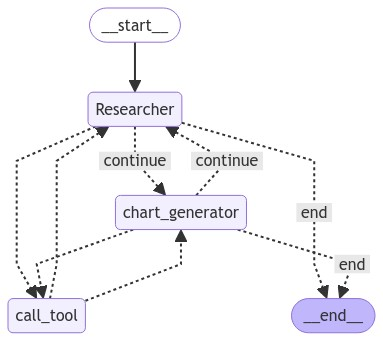

In [162]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [163]:
from langchain_core.messages import (
    BaseMessage,
    HumanMessage,
    ToolMessage,
)

In [164]:
qurry = "Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish."

config = {"recursion_limit": 150}

events = graph.stream({"messages": [HumanMessage(content=qurry)]}, config)

for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 413, 'completion_tokens': 64, 'total_tokens': 477}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 413, 'completion_tokens': 64, 'total_tokens': 477}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, name='Researcher', id='run-f1c92007-2ef1-4d32-bdb2-218d19a562c3-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'UK GDP past 5 years'}, 'id': 'toolu_bdrk_0194sZiucuyVjQDh7hTh5krq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 413, 'output_tokens': 64, 'total_tokens': 477})], 'sender': 'Researcher'}}
----
-----------> state:  {'messages': [HumanMessage(content="Fetch the UK's GDP over the past 5 years, then draw a line graph of it. Once you code it up, finish."), AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 413, 'completion_

In [166]:
qurry = "대한민국의 지난 10년간의 GDP를 찾으세요. 다음에 이 데이터를 가지고 line graph를 그리세요. 준비가 다 되면 마칩니다."
config = {"recursion_limit": 150}

events = graph.stream({"messages": [HumanMessage(content=qurry)]}, config)

for s in events:
    print(s)
    print("----")

{'Researcher': {'messages': [AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 448, 'completion_tokens': 66, 'total_tokens': 514}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, response_metadata={'usage': {'prompt_tokens': 448, 'completion_tokens': 66, 'total_tokens': 514}, 'stop_reason': 'tool_use', 'model_id': 'anthropic.claude-3-sonnet-20240229-v1:0'}, name='Researcher', id='run-5e6f5ce5-a9d0-4b65-bee8-5123c4eeb9d2-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'south korea gdp last 10 years'}, 'id': 'toolu_bdrk_01R38yKoagFbe3h7hH9pwbAn', 'type': 'tool_call'}], usage_metadata={'input_tokens': 448, 'output_tokens': 66, 'total_tokens': 514})], 'sender': 'Researcher'}}
----
-----------> state:  {'messages': [HumanMessage(content='대한민국의 지난 10년간의 GDP를 찾으세요. 다음에 이 데이터를 가지고 line graph를 그리세요. 준비가 다 되면 마칩니다.'), AIMessage(content='', additional_kwargs={'usage': {'prompt_tokens': 448, 'completion_tokens': 66, 'tot